# Email campaign analytics
                            

### Data 
Dataset related to email campaigns of different departmental stores has been provided.

In this work, After exploratory analysis of the data, regression model has been fitted with independent variable as readRatePercent.

In [171]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#Imprting Data

#considering null as Na values
# parsing date columns
df = pd.read_excel("L2-sample_data.xlsx",sheet_name=0,na_values='null',
                   parse_dates=['lastSeen','firstSeen'])
df.info()
#df.describe()
#df.shape
#df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53868 entries, 0 to 53867
Data columns (total 20 columns):
brand                    53868 non-null object
hasCreative              53868 non-null bool
projectedVolume          53868 non-null int64
campaignId               53868 non-null int64
lastSeen                 53868 non-null datetime64[ns]
spamCount                53868 non-null int64
readDeleteRatePercent    52025 non-null float64
subject                  53867 non-null object
fromAddress              53868 non-null object
mobileReady              53868 non-null bool
isCommercial             53868 non-null bool
firstSeen                53868 non-null datetime64[ns]
imageDownloadUrl         47298 non-null object
percentOfList            51911 non-null float64
readRatePercent          52025 non-null float64
deleteRatePercent        52025 non-null float64
personalized             53868 non-null bool
inboxCount               53867 non-null object
lang                     53868 non-n

### Brands

The column Brand contains the different brands in the dataset. There are 57 brands, NeimanMarcus has the most number of observations.

In [172]:
#Number of brands
df.brand.nunique()
# 57 brands

# Number of obs for each brand
#top 10 brands

df.brand.value_counts().head(10)
# NeimanMarcus has highest 4469
df.brand.value_counts().tail()

57

NeimanMarcus    4469
JCPenney        3934
Sears           3245
Macys           2900
Asos            2171
BonTon          2083
Saks            2054
Gilt            2016
Yoox            1904
Kohls           1848
Name: brand, dtype: int64

Liverpool          59
El Corte Ingles    57
LeBonMarche        47
Kadewe             45
Daimaru             1
Name: brand, dtype: int64

### Selection of a departmental store 

I have selected JcPenney for the from the brands for the further exploration

 - Jcpenney has second highest number of observations and only 2 missing values for readRatePercent variable.

  

In [42]:
#df.brand[df.readRatePercent.isnull()].value_counts(dropna=False)
#JcPenny has only 2 missing values, Nm has 27,

#df.brand[df.readRatePercent == 0].value_counts(dropna=False)
#JcPenny has 142 zero read rate percent
#df.dtypes

On checking the datatypes of the variables, The variable inboxCount is object type, it should be a numeric.

 - Converting inboxCount to numeric
 

In [173]:

#inbox count should not be object type, finding non int values
icList = [i for i in df.inboxCount.unique() if type(i) !=int ]

# replacing these values
for _ in icList: 
    df.loc[df.inboxCount == _ , 'inboxCount'] = np.NaN

df.inboxCount = df.inboxCount.apply(pd.to_numeric)


#### New features
- Image imageDownloadUrl has null values, a new variable hasImage is created from it
- Varaible containing word counts for the subject is created.
- For this work, I have not used variable 'imageDownloadUrl', so have dropped it along with subject(Dataset has trans) and lang variables


In [174]:
#null vals in imageDownloadUrl
#df.imageDownloadUrl.isnull().sum()

df['hasImage']= np.where(df.imageDownloadUrl.isnull(),0,1)

df['subLen']= df.trans.apply(len)

#dropping cols
df = df.drop(['subject', 'imageDownloadUrl','lang'], axis=1)
#df.info()

### Benchmarking

For benchmarking the performance of email campaign of JcPenney, comaprison has been done with the overall brands and the four similar competitors.


Text(0.5,1,'Histogram for readRatePercent of JcPenney')

Avearge for the Read rate percent for the Jc Penney : 0.209
Avearge for the Read rate percent for all the stores : 0.188
Avearge for the Read rate percent for the segment : 0.188


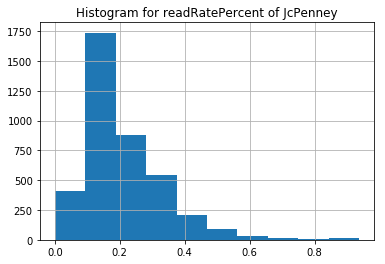

In [45]:
#creating a new dataset for Jcpenney
Jc = df.loc[df.brand == 'JCPenney',:]

# exploring Jcpenney and read rate percent
Jc.readRatePercent.hist()
plt.title("Histogram for readRatePercent of JcPenney")

#Creating dataset for the Jcpenney segements
comp = df[df['brand'].isin(['Sears','Macys','Kohls','Nordstrom','JCPenney'])]


#mean of the read rate percent
print("Avearge for the Read rate percent for the Jc Penney :",round(Jc.readRatePercent.mean(),3))
print("Avearge for the Read rate percent for all the stores :",round(df.readRatePercent.mean(),3))
print("Avearge for the Read rate percent for the segment :",round(comp.readRatePercent.mean(),3))


-  The average readRatePercent value for JcPenney is 20.9%
-  We can see that the JcPenney is performing better than the overall, average for the industry and its competitors.
-  The comaprison can be seen through the following boxplot
-  The market leaders for the read rate percent are as follows

In [46]:
df.groupby('brand')['readRatePercent'].mean().nlargest(5)

brand
DavidJones         0.393713
LeBonMarche        0.346021
Debijenkorf        0.315533
Next               0.263730
MarksandSpencer    0.259628
Name: readRatePercent, dtype: float64

#### Functions to create plots 

 - Functions to create box plot and regplot
 - Regression plot is to see the relation between contious variable

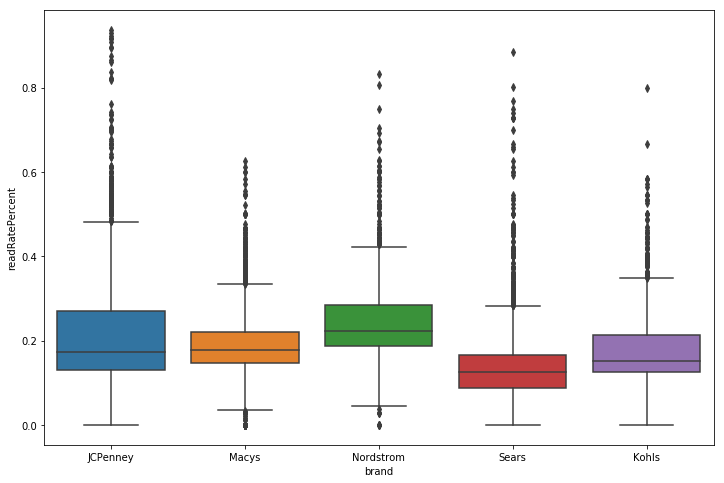

In [61]:
# creating boxplot with default argument as target variable and data as Jc 
import seaborn as sns 
def boxPlot(var,y='readRatePercent',data=Jc):
    return sns.boxplot(x=var,y=y,data=data)

# Regplot for numerc relations
def regPlot(var,by=None,order=1):
    return sns.lmplot(x=var,y='readRatePercent',data=Jc,hue=by,order=order)

f, ax = plt.subplots(figsize=(12, 8))
boxPlot('brand',data=comp)


#### Exploring Categorical features

Next, the relation of categorical features such as Personalized and hasCreative has been explored.

- Again for exploring the proportion of target variable with the mean, appropriate functions have been created.
- The variation of the target variable readRatePercent with the  categorical variables  for all the brands and the Jcpenney is analyzed. 



In [48]:

def prop(data,colBy,colWith):
    # to cal prop of proportion with target var
    return data.groupby(colBy)[colWith].mean()

print("Average for the Read rate percent for all barands with:",prop(df,'hasCreative','readRatePercent'))
print("\nAverage for the Read rate percent for JcPennney with:",prop(Jc,'hasCreative','readRatePercent'))


#Similarly we can see the realtion for the other variables

prop(Jc,'hasImage','readRatePercent')
prop(df,'hasImage','readRatePercent')

#prop(Jc,'mobileReady','readRatePercent')
#prop(df,'mobileReady','readRatePercent')


#prop(Jc,'isCommercial','readRatePercent')
#isCommercial true for Jc 
#prop(df,'isCommercial','readRatePercent')


#deleteRatePercent and hasCreative
#prop(Jc,'hasCreative','deleteRatePercent')

#prop(Jc,'hasCreative','readDeleteRatePercent')


Average for the Read rate percent for all barands with: hasCreative
False    0.219056
True     0.183073
Name: readRatePercent, dtype: float64

Average for the Read rate percent for JcPennney with: hasCreative
False    0.256677
True     0.202917
Name: readRatePercent, dtype: float64


hasImage
0    0.256677
1    0.202917
Name: readRatePercent, dtype: float64

hasImage
0    0.219056
1    0.183073
Name: readRatePercent, dtype: float64

#### Key Insights

- For both hasCreative and mobileReady average readRatePercent is high when the values are False
- Average readRatePercent is high when the email doesnot contain email
- Variable is isCommercial has only one level so can be dropped
- hasCreative has inverse relation for readDeleteRatePercent and deleteRatePercent

#### Personalized has very prominent relation with the readRatePercent

Personalized emails have very high readRatePercent 

personalized
False    0.199588
True     0.361000
Name: readRatePercent, dtype: float64

personalized
False    0.185203
True     0.209208
Name: readRatePercent, dtype: float64

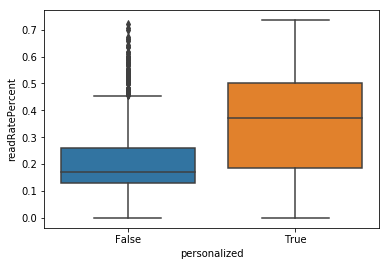

In [103]:
prop(Jc,'personalized','readRatePercent')
# prsonalized work very well for Jc
#prop(comp,'personalized','readRatePercent')
prop(df,'personalized','readRatePercent')

boxPlot('personalized')

#### fromAdress

- On further exploration of the variable fromAddress one can see that the account address of Jcpenney has very highReadratePercent
- The subject lines are related to password and expiration of account.
- The rows with this address should be dropped since the purpose of this address is not for advertising


In [50]:
Jc.fromAddress.unique()

prop(Jc,'fromAddress','readRatePercent')

Jc.groupby('fromAddress')['readRatePercent'].count()

#subject lines with the head
Jc[Jc.fromAddress == 'jcpenneyacct@e.jcpenney.com'].trans.head()

# dropping rows with Jc account address
Jc = Jc[(Jc.fromAddress != 'jcpenneyacct@e.jcpenney.com')]

# we can see the relation between subgroups 
Jc.groupby(['personalized','mobileReady'])['readRatePercent'].mean()


array(['jcpenney@e.jcpenney.com', 'jcpenneyacct@e.jcpenney.com'], dtype=object)

fromAddress
jcpenney@e.jcpenney.com        0.204633
jcpenneyacct@e.jcpenney.com    0.768183
Name: readRatePercent, dtype: float64

fromAddress
jcpenney@e.jcpenney.com        3904
jcpenneyacct@e.jcpenney.com      28
Name: readRatePercent, dtype: int64

14853    Here's how to reset your password
14905    Here's how to reset your password
15010    Here's how to reset your password
15091    Here's how to reset your password
15177    Here's how to reset your password
Name: trans, dtype: object

personalized  mobileReady
False         False          0.210612
              True           0.172816
True          False          0.378041
              True           0.303791
Name: readRatePercent, dtype: float64

### Imputatation of missing data

Rather than dropping rows with missing data, the imputation as per average of the different categorical variables is a better strategy

- Dropping cols brand, campaignId, fromAddress, isCommercial


In [55]:
#imputing missing values as per personalized and hasCreative

import warnings
warnings.filterwarnings('ignore')


group = Jc.groupby(['personalized','hasCreative'])
def imp(data):
    return data.fillna(data.mean())

#imputation
Jc.readDeleteRatePercent = group['readDeleteRatePercent'].transform(imp)

Jc.readRatePercent = group['readRatePercent'].transform(imp)
Jc.deleteRatePercent = group['deleteRatePercent'].transform(imp)
Jc.percentOfList = group['percentOfList'].transform(imp)


Jc = Jc.drop(['brand', 'campaignId','fromAddress','isCommercial'], axis=1)

### Numeric columns

Along with regression plot, the correlation plot depicts relation between numeric columns.
As we can see in the plot readRate has weak corr with most of the features



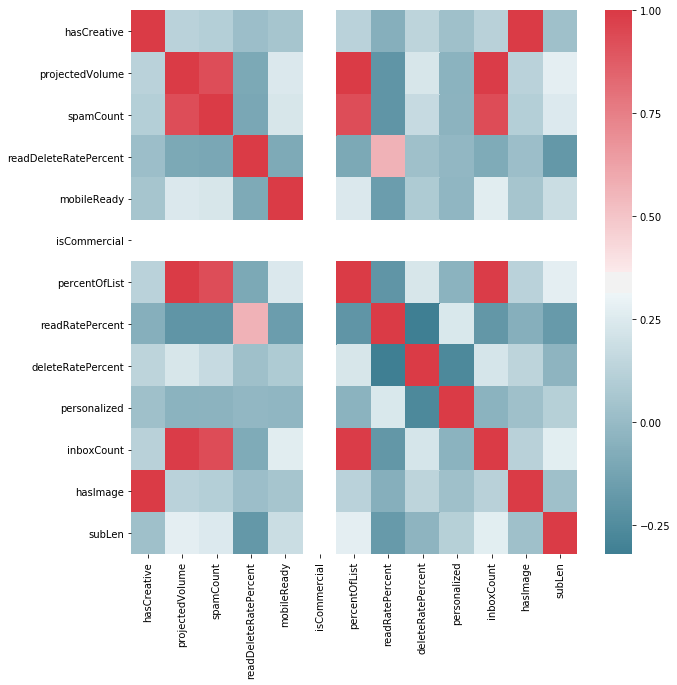

In [67]:
#Jc.info()
corr = Jc.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap=cmap,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

#print(df['projectedVolume'].corr(df['readRatePercent']))


- Using regPlot function we can draw plots for different numeric variables and see the realtion

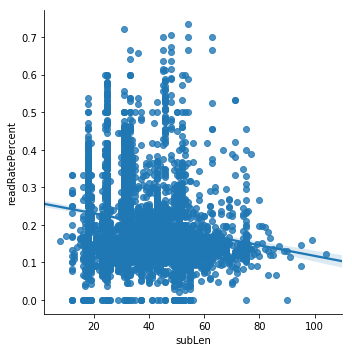

In [102]:
regPlot('subLen')

### Time series analysis

In this part I have analyzed monthly averages of the readRatePercent with firstSeen as the timeframe. The intution is there can be seasonal Trend in the readRate percent.
- Monthly averages have been increasing with a increase from November.
- Similar trend for all brands

firstSeen
April,2016        20.68
May,2016          19.64
June,2016         18.10
July,2016         17.88
August,2016       19.79
September,2016    18.48
October,2016      18.53
November,2016     22.95
December,2016     21.95
January,2017      21.63
February,2017     22.23
March,2017        22.39
April,2017        21.54
Name: readRatePercent, dtype: float64

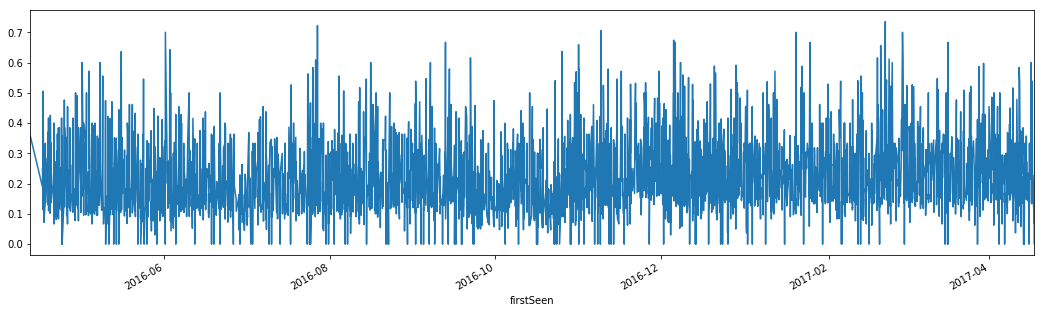

In [71]:
#time series 
JcTs = pd.Series(Jc.set_index('firstSeen')['readRatePercent'],index=Jc.firstSeen)

#JcTs = JcTs.dropna()
f, ax = plt.subplots(figsize=(18, 5))
JcTs.plot()

#monthly Average of readRate
round(JcTs.resample('M').mean().rename(index=lambda x: x.strftime('%B,%Y')),4)*100


In [73]:
# Monthly average for all brands
dfTs = pd.Series(df.set_index('firstSeen')['readRatePercent'],index=df.firstSeen)

dfTs = dfTs.dropna()

#monthly Average of readRate
round(dfTs.resample('M').mean().rename(index=lambda x: x.strftime('%B,%Y')),4)*100


# combine all in one df and plot

firstSeen
April,2016        17.92
May,2016          17.82
June,2016         17.67
July,2016         17.78
August,2016       17.84
September,2016    16.03
October,2016      16.17
November,2016     20.04
December,2016     20.30
January,2017      21.03
February,2017     20.34
March,2017        20.65
April,2017        20.40
Name: readRatePercent, dtype: float64

### Text Mining

The variable trans has subject lines translated to english, The content of the subject can greatly vary readRatePercent.
- For the analysis text from the data set has been divided into 2 interest levels high and low
- Also the text of the brands with the highest readRatePercent has been analyzed.

In [74]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

#Function to get n most commmon words
def MostComm(text,n):
    # Get most common words
    tokens = [token for token in nltk.word_tokenize(text.lower()) if token.isalpha()]
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    return Counter(tokens).most_common(n)


#subject lines with high readrate percent 
textH = " ".join(Jc.trans[Jc.readRatePercent > 0.25])

#20 most common words
MostComm(textH,20)


[('earned', 287),
 ('good', 206),
 ('news', 206),
 ('points', 206),
 ('thanks', 142),
 ('jcpenney', 135),
 ('reward', 122),
 ('shopping', 118),
 ('late', 115),
 ('waiting', 106),
 ('redacted', 100),
 ('congrats', 99),
 ('order', 81),
 ('ready', 64),
 ('extra', 58),
 ('item', 51),
 ('look', 38),
 ('thank', 36),
 ('ends', 36),
 ('shipped', 33)]

In [75]:
#subject lines with high readrate percent 
textL = " ".join(Jc.trans[Jc.readRatePercent < 0.17])

#20 most common words
MostComm(textL,20)

[('extra', 236),
 ('savings', 211),
 ('day', 189),
 ('save', 126),
 ('styles', 120),
 ('sale', 118),
 ('jcpenney', 96),
 ('new', 93),
 ('great', 89),
 ('confirm', 85),
 ('time', 84),
 ('get', 80),
 ('last', 79),
 ('home', 77),
 ('spring', 68),
 ('waiting', 66),
 ('summer', 64),
 ('open', 63),
 ('days', 61),
 ('select', 58)]

### WordPlay

- The analysis shows how the words like earned, points, reward increses the chances of email being read.
- The word Redacted shows the importance of personalisation of emails 
- The words only in high interest level but not in low interest level have been extracted

In [77]:
def getTokens(text):
    # Get tokens
    tokens = [token for token in nltk.word_tokenize(text.lower()) if token.isalpha()]
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    return tokens


def diff(text1,text2):
    #Get intersection of words    
    h = set(getTokens(text1))
    l = set(getTokens(text2))
    return [word for word in h if word not in l]

print(diff(textH,textL))

['featuring', 'appreciate', 'run', 'thousands', 'melting', 'reset', 'celebration', 'expire', 'perk', 'pickup', 'text', 'correct', 'clock', 'brand', 'urgent', 'routine', 'check', 'tardy', 'skin', 'messages', 'making', 'reminder', 'low', 'luck', 'sign', 'ticking', 'redeem', 'march', 'expires', 'puffers', 'longer', 'snow', 'password', 'leggings', 'survey']


- These are words that matter

##### Next the words for the brands with highest readRatePercent has been analyzed
- DavidJones, LeBonMarche, Debijenkorf

In [78]:
textTop3 = " ".join(df.trans[df['brand'].isin(['DavidJones','LeBonMarche','Debijenkorf'])])
 
print(MostComm(textTop3,20))


[('new', 67), ('save', 43), ('discover', 40), ('sale', 37), ('gift', 30), ('beauty', 30), ('fashion', 27), ('home', 26), ('range', 24), ('christmas', 24), ('season', 23), ('collection', 22), ('sunday', 22), ('items', 22), ('extra', 21), ('last', 20), ('ends', 20), ('redacted', 20), ('days', 20), ('today', 20)]


In [ ]:
textJc = " ".join(Jc.trans)

#printing 50 words that are in subjects of top3 but not in subjects of Jc 
print(diff(textTop3,textJc)[:50])

### Emos

- On the lighter node, I want to see the emos and the number of emos used in subject lines by top3 and JcPenney 

In [85]:
from nltk.tokenize import regexp_tokenize
#emoji ranges
emoji = "['\U0001F300-\U0001F5FF'|'\U0001F600-\U0001F64F'|'\U0001F680-\U0001F6FF'|'\u2600-\u26FF\u2700-\u27BF']"

#Get emos
def getEmo(text):
     return(set([ emo for emo in regexp_tokenize(text, emoji) if emo != "'"]))
    
print('The number of Emojis used by Top3 Brands are ',len(getEmo(textTop3)))

print('\nThe number of Emojis used by JcPenney are ',len(getEmo(textJc)))
print('The Emojis used by  JcPenney are ',getEmo(textJc))

The number of Emojis used by Top3 Brands are  0

The number of Emojis used by JcPenney are  24
The Emojis used by  JcPenney are  {'💡', '🔎', '🔥', '🍁', '☃', '❗', '🎁', '☀', '❤', '♥', '💎', '✨', '✔', '⚠', '💍', '👑', '👀', '💪', '🎄', '💃', '🎉', '🍀', '⚡', '🎃'}


#### Emos: Not recommended!!!!

- As we can see the the top brands with the highest read rate have not used any emos. 
- Next will explore emo usage differences in jcPenney high read rate and low read rate subject lines


In [88]:
print('The number of Emojis used by highly read subjects for JcPenney are ',len(getEmo(textH)))
print('The number of Emojis used by highly read subjects for JcPenney are ',len(getEmo(textL)))

The number of Emojis used by highly read subjects for JcPenney are  0
The number of Emojis used by highly read subjects for JcPenney are  18


- For Jcpenney also the subject lines with the emoji's have low readRatePercent
- It can be the scenario that the emails with the emojis in the subject go directly to spam
- Next will look into relation of the emoji count with the spam count

emoLen Vs readRatePercent
 emoLen
0    0.205060
1    0.166440
2    0.171324
Name: readRatePercent, dtype: float64


emoLen Vs spamCount
 emoLen
0     34.104091
1    108.146341
2    140.000000
Name: spamCount, dtype: float64


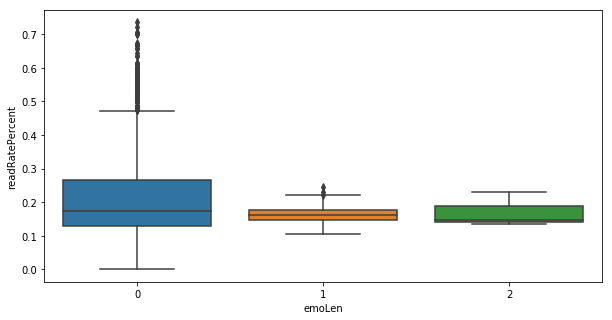

In [101]:
def emoLen(text):
    return len(set([ emo for emo in regexp_tokenize(text, emoji) if emo != "'"]))

# New variable
Jc['emoLen']= Jc.trans.apply(emoLen)

print("emoLen Vs readRatePercent\n",prop(Jc,'emoLen','readRatePercent'))

print("\n\nemoLen Vs spamCount\n",prop(Jc,'emoLen','spamCount'))

f, ax = plt.subplots(figsize=(10, 5))
boxPlot('emoLen')


This proves the hypothesis that the emoji's are directly related to lower readRatepercent, As emails which has emoji's in them have high chances of going to spam.


### Predictive Analytics

- In the last report a regression model has been fitted to the data using subject and some of the other columns.
- A pipeline using scikit learn has been created for fitting a model.
- Only variable for which responses are known prior to sending the email have been used for modelling.

For instance, variable such as spamCount and readDeleteRatePercent have not been used

##### Data preparation

In [175]:
#Jc.info()

In [113]:
# converting bools to numeric
Jc.hasCreative = Jc.hasCreative.astype(int)

Jc.mobileReady = Jc.mobileReady.astype(int)
Jc.personalized = Jc.personalized.astype(int)

#Preparing data for modelling
# variable selection
X = Jc.loc[:,['hasCreative','mobileReady','personalized','hasImage','subLen','emoLen','trans']]


y =Jc.readRatePercent

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3906 entries, 14830 to 18763
Data columns (total 7 columns):
hasCreative     3906 non-null int64
mobileReady     3906 non-null int64
personalized    3906 non-null int64
hasImage        3906 non-null int64
subLen          3906 non-null int64
emoLen          3906 non-null int64
trans           3906 non-null object
dtypes: int64(6), object(1)
memory usage: 404.1+ KB


#### Pipeline

- Since text data and numeric data needs different preprocessing steps, 
Functional transformers have been craeted and used in pipeline using union.

- For vectorizing text countVectorizer and Tfidf have been used.

In [114]:

#preparing data for pipeline
from sklearn.preprocessing import FunctionTransformer

# trans -Get text data from X
getTrans = FunctionTransformer(lambda x: x['trans'], validate=False)

#  Numerics
getNums = FunctionTransformer(lambda x: x[['hasCreative', 'mobileReady','hasImage','subLen','emoLen',
                                           'personalized']], validate=False)
  
 

In [120]:
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# creating a union object to combine text and numeric variables in a pipeline
# ngram as 2,3
union = FeatureUnion(
            transformer_list = [
                ('numerics', Pipeline([
                    ('selector', getNums )
                ])),
                ('text', Pipeline([
                    ('selector', getTrans),
                    ('vectorizer', TfidfVectorizer())
                ]))
             ]
        )
     

#### Linear regression
For base model, simple linear regression model has been fitted


In [122]:
from sklearn.linear_model import LinearRegression

pl = Pipeline([
        ('union', union),
        ('reg',  LinearRegression())
    ])

In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)



# Fit pl to the training data
pl.fit(X_train, y_train)               
                

r2 = pl.score(X_test, y_test)

print(r2)


Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numerics', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x106874510>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
 ...ights=None)), ('reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

0.340374308048


- For simple linear regression model r2 is 0.34
- RMSE is 0.09

In [124]:
from sklearn.metrics import mean_squared_error
y_pred = pl.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


Root Mean Squared Error: 0.09432190649526001


In [129]:
import xgboost as xgb
# fitting xgbRegressor
pl = Pipeline([
        ('union', union),
        ("xgb_model", xgb.XGBRegressor( objective="reg:linear"))
    ])


pl.fit(X_train, y_train)               
                
r2 = pl.score(X_test, y_test)

print(r2)
y_pred = pl.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


('xgb_model',
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
        n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1))

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numerics', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x106874510>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
 ...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

0.500174697612
Root Mean Squared Error: 0.0821056243157489


###### With simple xgboost regressor 
- R2 0.500174697612
- Root Mean Squared Error: 0.0821056243157489

In [157]:
pl = Pipeline([
        ('union', union),
        ("xgb_model", xgb.XGBRegressor( objective="reg:linear",colsample_bytree=0.3,n_estimators=200))
    ])


pl.fit(X_train, y_train)               
                
r2 = pl.score(X_test, y_test)

print(r2)
y_pred = pl.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))



Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numerics', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x106874510>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
 ...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

0.507136512805
Root Mean Squared Error: 0.08153181526654418


In [170]:
# parameter tuning
from sklearn.model_selection import GridSearchCV
grid = {
    'xgb_model__learning_rate': np.arange(.05,0.1 ,.05),
    'xgb_model__max_depth': np.arange(3,10, 1),
    'xgb_model__n_estimators': np.arange(100, 1000, 100),
    'xgb_model__colsample_bytree': np.arange(0.2, 0.6, 0.1),
    'xgb_model__gamma': np.arange(0, 2, 0.5)
}

pl1 = Pipeline([
        ('union', union),
        ("xgb_model", xgb.XGBRegressor( objective="reg:linear"))
    ])



cv = GridSearchCV(estimator=pl1,
                          param_grid=grid,
                          cv=3, verbose=1)



cv.fit(X_train, y_train) 

# metrics
print(cv.best_score_)
print(cv.best_estimator_)


Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


[Parallel(n_jobs=1)]: Done 3024 out of 3024 | elapsed: 42.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numerics', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x106874510>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
 ...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'xgb_model__learning_rate': array([ 0.05]), 'xgb_model__max_depth': array([3, 4, 5, 6, 7, 8, 9]), 'xgb_model__n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]), 'xgb_model__colsample_bytree': array([ 0.2,  0.3,  0.4,  0.5]), 'xgb_model__gamma': array([ 0. ,  0.5,  1. ,  1.5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

0.483426519232
Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numerics', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x106874510>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
 ... reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))])


- Due ro time constraints I have not focused much on the modeling part
- My major focus was on understading the data better, as I feel this is the most important factor for modeling

#### Conclusion

- The success of the campaign is very much predictable. 
- Data analytics can make a huge dufference in performance of the email camapign analytics.